## CS 224N Lecture 3: Word Window Classification

### Pytorch Exploration

### Author: Matthew Lamm

In [1]:
import pprint
import torch
import torch.nn as nn
pp = pprint.PrettyPrinter()

## Our Data

The task at hand is to assign a label of 1 to words in a sentence that correspond with a LOCATION, and a label of 0 to everything else. 

In this simplified example, we only ever see spans of length 1.

In [2]:
train_sents = [s.lower().split() for s in ["we 'll always have Paris",
                                           "I live in Germany",
                                           "He comes from Denmark",
                                           "The capital of Denmark is Copenhagen"]]
train_labels = [[0, 0, 0, 0, 1],
                [0, 0, 0, 1],
                [0, 0, 0, 1],
                [0, 0, 0, 1, 0, 1]]

assert all([len(train_sents[i]) == len(train_labels[i]) for i in range(len(train_sents))])


In [5]:
test_sents = [s.lower().split() for s in ["She comes from Paris"]]
test_labels = [[0, 0, 0, 1]]

assert all([len(test_sents[i]) == len(test_labels[i]) for i in range(len(test_sents))])

## Creating a dataset of batched tensors.

PyTorch (like other deep learning frameworks) is optimized to work on __tensors__, which can be thought of as a generalization of vectors and matrices with arbitrarily large rank.

Here well go over how to translate data to a list of vocabulary indices, and how to construct *batch tensors* out of the data for easy input to our model. 

We'll use the *torch.utils.data.DataLoader* object handle ease of batching and iteration.

### Converting tokenized sentence lists to vocabulary indices.

Let's assume we have the following vocabulary:

In [6]:
id_2_word = ["<pad>", "<unk>", "we", "always", "have", "paris",
              "i", "live", "in", "germany",
              "he", "comes", "from", "denmark",
              "the", "of", "is", "copenhagen"]
word_2_id = {w:i for i,w in enumerate(id_2_word)}

In [9]:
instance = train_sents[0]
print(instance)

['we', "'ll", 'always', 'have', 'paris']


In [10]:
def convert_tokens_to_inds(sentence, word_2_id):
    return [word_2_id.get(t, word_2_id["<unk>"]) for t in sentence]

In [11]:
token_inds = convert_tokens_to_inds(instance, word_2_id)
pp.pprint(token_inds)

[2, 1, 3, 4, 5]


Let's convince ourselves that worked:

In [12]:
print([id_2_word[tok_idx] for tok_idx in token_inds])

['we', '<unk>', 'always', 'have', 'paris']


### Padding for windows.

In the word window classifier, for each word in the sentence we want to get the +/- n window around the word, where 0 <= n < len(sentence).

In order for such windows to be defined for words at the beginning and ends of the sentence, we actually want to insert padding around the sentence before converting to indices:

In [13]:
def pad_sentence_for_window(sentence, window_size, pad_token="<pad>"):
    return [pad_token]*window_size + sentence + [pad_token]*window_size 

In [14]:
window_size = 2
instance = pad_sentence_for_window(train_sents[0], window_size)
print(instance)

['<pad>', '<pad>', 'we', "'ll", 'always', 'have', 'paris', '<pad>', '<pad>']


Let's make sure this works with our vocabulary:

In [15]:
for sent in train_sents:
    tok_idxs = convert_tokens_to_inds(pad_sentence_for_window(sent, window_size), word_2_id)
    print([id_2_word[idx] for idx in tok_idxs])

['<pad>', '<pad>', 'we', '<unk>', 'always', 'have', 'paris', '<pad>', '<pad>']
['<pad>', '<pad>', 'i', 'live', 'in', 'germany', '<pad>', '<pad>']
['<pad>', '<pad>', 'he', 'comes', 'from', 'denmark', '<pad>', '<pad>']
['<pad>', '<pad>', 'the', '<unk>', 'of', 'denmark', 'is', 'copenhagen', '<pad>', '<pad>']


### Batching sentences together with a DataLoader

When we train our model, we rarely update with respect to a single training instance at a time, because a single instance provides a very noisy estimate of the global loss's gradient. We instead construct small *batches* of data, and update parameters for each batch. 

Given some batch size, we want to construct batch tensors out of the word index lists we've just created with our vocab.

For each length B list of inputs, we'll have to:

    (1) Add window padding to sentences in the batch like we just saw.
    (2) Add additional padding so that each sentence in the batch is the same length.
    (3) Make sure our labels are in the desired format.

At the level of the dataest we want:

    (4) Easy shuffling, because shuffling from one training epoch to the next gets rid of 
        pathological batches that are tough to learn from.
    (5) Making sure we shuffle inputs and their labels together!
    
PyTorch provides us with an object *torch.utils.data.DataLoader* that gets us (4) and (5). All that's required of us is to specify a *collate_fn* that tells it how to do (1), (2), and (3). 

In [16]:
l = torch.LongTensor(train_labels[0])
pp.pprint(("raw train label instance", l))
print(l.size())


('raw train label instance', tensor([0, 0, 0, 0, 1]))
torch.Size([5])


In [17]:
one_hots = torch.zeros((2, len(l)))
pp.pprint(("unfilled label instance", one_hots))
print(one_hots.size())

('unfilled label instance',
 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]))
torch.Size([2, 5])


In [18]:
one_hots[1] = l
pp.pprint(("one-hot labels", one_hots))

('one-hot labels', tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]]))


In [22]:
l_not = ~l.byte()
one_hots[0] = l_not
pp.pprint(("one-hot labels", one_hots))

('one-hot labels', tensor([[1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 1.]]))


In [23]:
from torch.utils.data import DataLoader
from functools import partial

In [27]:
torch.LongTensor(tok_idxs)

tensor([ 0,  0, 14,  1, 15, 13, 16, 17,  0,  0])

In [53]:
torch.LongTensor([1,0,1]).long().dtype

torch.int64

In [58]:
nn.utils.rnn.pad_sequence([torch.ones(3, 5), torch.ones(4,5)], batch_first=False)

tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.]]])

In [54]:
def my_collate(data, window_size, word_2_id):
    """
    For some chunk of sentences and labels
        -add winow padding
        -pad for lengths using pad_sequence
        -convert our labels to one-hots
        -return padded inputs, one-hot labels, and lengths
    """
    
    x_s, y_s = zip(*data)

    # deal with input sentences as we've seen
    window_padded = [convert_tokens_to_inds(pad_sentence_for_window(sentence, window_size), word_2_id)
                                                                                  for sentence in x_s]
    # append zeros to each list of token ids in batch so that they are all the same length
    padded = nn.utils.rnn.pad_sequence([torch.LongTensor(t) for t in window_padded], batch_first=True)
    
    # convert labels to one-hots
    labels = []
    lengths = []
    for y in y_s:
        lengths.append(len(y))
        label = torch.zeros((len(y),2 ))
        true = torch.LongTensor(y) 
        false = ~true.byte()
        label[:, 0] = false
        label[:, 1] = true
        labels.append(label)
    padded_labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    
    return padded.long(), padded_labels, torch.LongTensor(lengths)

In [56]:
# Shuffle True is good practice for train loaders.
# Use functools.partial to construct a partially populated collate function
example_loader = DataLoader(list(zip(train_sents, 
                                                      train_labels)), 
                                             batch_size=2, 
                                             shuffle=True, 
                                             collate_fn=partial(my_collate, window_size=2, word_2_id=word_2_id))

In [59]:
for batched_input, batched_labels, batch_lengths in example_loader:
    pp.pprint(("inputs", batched_input, batched_input.size()))
    pp.pprint(("labels", batched_labels, batched_labels.size()))
    pp.pprint(batch_lengths)
    break

('inputs',
 tensor([[ 0,  0, 14,  1, 15, 13, 16, 17,  0,  0],
        [ 0,  0,  2,  1,  3,  4,  5,  0,  0,  0]]),
 torch.Size([2, 10]))
('labels',
 tensor([[[1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 0.]]]),
 torch.Size([2, 6, 2]))
tensor([6, 5])


## Modeling

### Thinking through vectorization of word windows.
Before we go ahead and build our model, let's think about the first thing it needs to do to its inputs.

We're passed batches of sentences. For each sentence i in the batch, for each word j in the sentence, we want to construct a single tensor out of the embeddings surrounding word j in the +/- n window.

Thus, the first thing we're going to need a (B, L, 2N+1) tensor of token indices.

A *terrible* but nevertheless informative *iterative* solution looks something like the following, where we iterate through batch elements in our (dummy), iterating non-padded word positions in those, and for each non-padded word position, construct a window:

In [60]:
dummy_input = torch.zeros(2, 8).long()
dummy_input[:,2:-2] = torch.arange(1,9).view(2,4)
pp.pprint(dummy_input)

tensor([[0, 0, 1, 2, 3, 4, 0, 0],
        [0, 0, 5, 6, 7, 8, 0, 0]])


In [49]:
dummy_output = [[[dummy_input[i, j-2+k].item() for k in range(2*2+1)] 
                                                     for j in range(2, 6)] 
                                                            for i in range(2)]
dummy_output = torch.LongTensor(dummy_output)
print(dummy_output.size())
pp.pprint(dummy_output)

torch.Size([2, 4, 5])
tensor([[[0, 0, 1, 2, 3],
         [0, 1, 2, 3, 4],
         [1, 2, 3, 4, 0],
         [2, 3, 4, 0, 0]],

        [[0, 0, 5, 6, 7],
         [0, 5, 6, 7, 8],
         [5, 6, 7, 8, 0],
         [6, 7, 8, 0, 0]]])


*Technically* it works: For each element in the batch, for each word in the original sentence and ignoring window padding, we've got the 5 token indices centered at that word. But in practice will be crazy slow.

Instead, we ideally want to find the right tensor operation in the PyTorch arsenal. Here, that happens to be __Tensor.unfold__.

In [70]:
dummy_input.unfold(1, 2*2+1, 1)

tensor([[[0, 0, 1, 2, 3],
         [0, 1, 2, 3, 4],
         [1, 2, 3, 4, 0],
         [2, 3, 4, 0, 0]],

        [[0, 0, 5, 6, 7],
         [0, 5, 6, 7, 8],
         [5, 6, 7, 8, 0],
         [6, 7, 8, 0, 0]]])

### A model in full.

In PyTorch, we implement models by extending the nn.Module class. Minimally, this requires implementing an *\_\_init\_\_* function and a *forward* function.

In *\_\_init\_\_* we want to store model parameters (weights) and hyperparameters (dimensions).


In [71]:
class SoftmaxWordWindowClassifier(nn.Module):
    """
    A one-layer, binary word-window classifier.
    """
    def __init__(self, config, vocab_size, pad_idx=0):
        super(SoftmaxWordWindowClassifier, self).__init__()
        """
        Instance variables.
        """
        self.window_size = 2*config["half_window"]+1
        self.embed_dim = config["embed_dim"]
        self.hidden_dim = config["hidden_dim"]
        self.num_classes = config["num_classes"]
        self.freeze_embeddings = config["freeze_embeddings"]
        
        """
        Embedding layer
        -model holds an embedding for each layer in our vocab
        -sets aside a special index in the embedding matrix for padding vector (of zeros)
        -by default, embeddings are parameters (so gradients pass through them)
        """
        self.embed_layer = nn.Embedding(vocab_size, self.embed_dim, padding_idx=pad_idx)
        if self.freeze_embeddings:
            self.embed_layer.weight.requires_grad = False
        
        """
        Hidden layer
        -we want to map embedded word windows of dim (window_size+1)*self.embed_dim to a hidden layer.
        -nn.Sequential allows you to efficiently specify sequentially structured models
            -first the linear transformation is evoked on the embedded word windows
            -next the nonlinear transformation tanh is evoked.
        """
        self.hidden_layer = nn.Sequential(nn.Linear(self.window_size*self.embed_dim, 
                                                    self.hidden_dim), 
                                          nn.Tanh())
        
        """
        Output layer
        -we want to map elements of the output layer (of size self.hidden dim) to a number of classes.
        """
        self.output_layer = nn.Linear(self.hidden_dim, self.num_classes)
        
        """
        Softmax
        -The final step of the softmax classifier: mapping final hidden layer to class scores.
        -pytorch has both logsoftmax and softmax functions (and many others)
        -since our loss is the negative LOG likelihood, we use logsoftmax
        -technically you can take the softmax, and take the log but PyTorch's implementation
         is optimized to avoid numerical underflow issues.
        """
        self.log_softmax = nn.LogSoftmax(dim=2)
        
    def forward(self, inputs):
        """
        Let B:= batch_size
            L:= window-padded sentence length
            D:= self.embed_dim
            S:= self.window_size
            H:= self.hidden_dim
            
        inputs: a (B, L) tensor of token indices
        """
        B, L = inputs.size()
        
        """
        Reshaping.
        Takes in a (B, L) LongTensor
        Outputs a (B, L~, S) LongTensor
        """
        # Fist, get our word windows for each word in our input.
        token_windows = inputs.unfold(1, self.window_size, 1)
        _, adjusted_length, _ = token_windows.size()
        
        # Good idea to do internal tensor-size sanity checks, at the least in comments!
        assert token_windows.size() == (B, adjusted_length, self.window_size)
        
        """
        Embedding.
        Takes in a torch.LongTensor of size (B, L~, S) 
        Outputs a (B, L~, S, D) FloatTensor.
        """
        embedded_windows = self.embed_layer(token_windows)
        
        """
        Reshaping.
        Takes in a (B, L~, S, D) FloatTensor.
        Resizes it into a (B, L~, S*D) FloatTensor.
        -1 argument "infers" what the last dimension should be based on leftover axes.
        """
        embedded_windows = embedded_windows.view(B, adjusted_length, -1)
        
        """
        Layer 1.
        Takes in a (B, L~, S*D) FloatTensor.
        Resizes it into a (B, L~, H) FloatTensor
        """
        layer_1 = self.hidden_layer(embedded_windows)
        
        """
        Layer 2
        Takes in a (B, L~, H) FloatTensor.
        Resizes it into a (B, L~, 2) FloatTensor.
        """
        output = self.output_layer(layer_1)
        
        """
        Softmax.
        Takes in a (B, L~, 2) FloatTensor of unnormalized class scores.
        Outputs a (B, L~, 2) FloatTensor of (log-)normalized class scores.
        """
        output = self.log_softmax(output)
        
        return output

### Training.

Now that we've got a model, we have to train it.

In [72]:
def loss_function(outputs, labels, lengths):
    """Computes negative LL loss on a batch of model predictions."""
    B, L, num_classes = outputs.size()
    num_elems = lengths.sum().float()
        
    # get only the values with non-zero labels
    loss = outputs*labels
    
    # rescale average
    return -loss.sum() / num_elems

In [186]:
def train_epoch(loss_function, optimizer, model, train_data):
    
    ## For each batch, we must reset the gradients
    ## stored by the model.   
    total_loss = 0
    for batch, labels, lengths in train_data:
        # clear gradients
        optimizer.zero_grad()
        # evoke model in training mode on batch
        outputs = model.forward(batch)
        # compute loss w.r.t batch
        loss = loss_function(outputs, labels, lengths)
        # pass gradients back, startiing on loss value
        loss.backward()
        # update parameters
        optimizer.step()
        total_loss += loss.item()
    
    # return the total to keep track of how you did this time around
    return total_loss
    

In [187]:
config = {"batch_size": 4,
          "half_window": 2,
          "embed_dim": 25,
          "hidden_dim": 25,
          "num_classes": 2,
          "freeze_embeddings": False,
         }
learning_rate = .0002
num_epochs = 10000
model = SoftmaxWordWindowClassifier(config, len(word_2_id))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [188]:
train_loader = torch.utils.data.DataLoader(list(zip(train_sents, train_labels)), 
                                           batch_size=2, 
                                           shuffle=True, 
                                           collate_fn=partial(my_collate, window_size=2, word_2_id=word_2_id))

In [190]:
losses = []
for epoch in range(num_epochs):
    epoch_loss = train_epoch(loss_function, optimizer, model, train_loader)
    if epoch % 100 == 0:
        losses.append(epoch_loss)
print(losses)

[1.2859952449798584, 1.2333113551139832, 1.1710911989212036, 1.112853229045868, 1.0624035000801086, 1.018785297870636, 0.9729363322257996, 0.9290077388286591, 0.886812835931778, 0.8421730995178223, 0.8070692121982574, 0.7720680832862854, 0.7294342219829559, 0.7008131742477417, 0.6615160405635834, 0.6353007853031158, 0.6046839356422424, 0.5755335092544556, 0.5460129678249359, 0.5214090049266815, 0.49638181924819946, 0.47115807235240936, 0.4502647817134857, 0.42908746004104614, 0.40778084099292755, 0.38899384438991547, 0.37128259241580963, 0.3521493673324585, 0.34000226855278015, 0.32176487147808075, 0.30788759887218475, 0.2948278784751892, 0.28564780950546265, 0.27298811078071594, 0.26200272142887115, 0.25165286660194397, 0.24189625680446625, 0.23354514688253403, 0.2248222753405571, 0.2139989584684372, 0.20878847688436508, 0.20141373574733734, 0.1936834454536438, 0.18708601593971252, 0.18155588954687119, 0.17490669339895248, 0.16927722096443176, 0.16393530368804932, 0.15885001420974731,

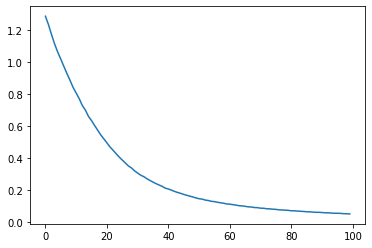

In [194]:
from matplotlib import pyplot as plt
plt.plot([i for i,l in enumerate(losses)], losses)
plt.show()

### Prediction.

In [195]:
test_loader = torch.utils.data.DataLoader(list(zip(test_sents, test_labels)), 
                                           batch_size=1, 
                                           shuffle=False, 
                                           collate_fn=partial(my_collate, window_size=2, word_2_id=word_2_id))

In [196]:
for test_instance, labs, _ in test_loader:
    outputs = model.forward(test_instance)
    print(torch.argmax(outputs, dim=2))
    print(torch.argmax(labs, dim=2))

tensor([[0, 0, 0, 1]])
tensor([[0, 0, 0, 1]])
